___
<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

#### 모델 준비

여기에서는 [카카오 나노 2.1b Instruct 모델](https://huggingface.co/kakaocorp/kanana-nano-2.1b-instruct)을 사용하겠습니다. 사용자의 지시를 수행할 수 있도록 미세조정이 되어 있는 모델입니다. 이 모델에 추가로 커스텀 질문답변 데이터셋을 훈련시켜보겠습니다.

업데이트
- [MS Phi-4-mini-instruct](https://huggingface.co/microsoft/Phi-4-mini-instruct)도 4090에서 파인튜닝되는 것을 확인했습니다. MIT 라이센스입니다.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "kakaocorp/kanana-nano-2.1b-instruct" # "-instruct" 지시에 따르도록 파인튜닝(사후훈련)이 된 모델
# model_name = "kakaocorp/kanana-nano-2.1b-base" # base 모델로도 지시 훈련이 됩니다.
# model_name = "microsoft/Phi-4-mini-instruct" # MIT 라이센스라서 상업적 사용 가능, 아래에서 epoch 50번 정도면 훈련 됩니다.

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    # torch_dtype="auto", # Phi-4-mini 모델
    trust_remote_code=True,
).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token # <|eot_id|> 128009

챗 메시지 템플릿 적용 예시

| Token               | ID  |
|---------------------|--------|
| <\|begin_of_text\|>   | 128000 |
| <\|end_of_text\|>     | 128001 |
| <\|start_header_id\|> | 128006 |
| <\|end_header_id\|>   | 128007 |
| <\|eot_id\|>          | 128009 |
| \n\n                  | 127 |


챗템플릿 적용 (토큰화 X)
```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou ... kakao.<|eot_id|>
<|start_header_id|>user<|end_header_id|>\n\n홍정모가 ... ?<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>\n\n홍정모는 헬다이버즈2를 ... <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>\n\n
```

토큰화 후
```
128000, 128006, 9125, 128007, 271, 2675, 527, ... , 128009, 
128006, 882, 128007, 271, 112032, 30381, 101555, 20565, 117004, 44005, 108573, 34804, 30, 128009, 
128006, 78191, 128007, 271, 112032, ..., 13, 128009, 
128006, 78191, 128007, 271
```



In [2]:
messages = [
    {"role": "system", "content": "You are a helpful AI assistant developed by Kakao."},
    {"role": "user", "content": "홍정모가 좋아하는 게임은?"},
    {"role": "assistant", "content":"홍정모는 헬다이버즈2를 좋아해서 자주합니다."}
]

tokens = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print(tokens)
#print(tokenizer.encode(tokens, add_special_tokens=False))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful AI assistant developed by Kakao.<|eot_id|><|start_header_id|>user<|end_header_id|>

홍정모가 좋아하는 게임은?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

홍정모는 헬다이버즈2를 좋아해서 자주합니다.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [3]:
qna_list = []
with open("jmcustomdata.txt", "r") as file:
    for line in file:
        qna = line.strip().split('|') # 안내: 입력 문서의 '|'는 질문과 답변을 구분하는 문자
        messages = [
            {"role": "system", "content": "You are a helpful AI assistant developed by Kakao."}, # 모든 질문 공통
            {"role": "user", "content": qna[0]},     # 질문 부분
            {"role": "assistant", "content": qna[1]} # 답변 부분
        ]
        q = tokenizer.apply_chat_template(messages[:2], tokenize=False, add_generation_prompt=True)
        input_str = tokenizer.apply_chat_template(messages[:3], tokenize=False, add_generation_prompt=True)
        # print(input_str)
        input_str = input_str[:-len('start_header_id\>assistant<|end_header_id|>')-4]
        # print(input_str)
        # print("--------------")
        q_ids = tokenizer.encode(q, add_special_tokens=False)
        input_ids = tokenizer.encode(input_str, add_special_tokens=False)
        qna_list.append({'q':q, 'input':input_str, 'q_ids':q_ids, 'input_ids':input_ids})

max_length = max(len(i['input_ids']) for i in qna_list)

print(qna_list)
print(max_length) # 토큰화 후에 가장 긴 길이 (패딩으로 채우기 위함)

[{'q': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful AI assistant developed by Kakao.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n다음 숫자들을 얘기해봐 12345<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n', 'input': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful AI assistant developed by Kakao.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n다음 숫자들을 얘기해봐 12345<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n67890.<|eot_id|>', 'q_ids': [128000, 128006, 9125, 128007, 271, 2675, 527, 264, 11190, 15592, 18328, 8040, 555, 75571, 3524, 13, 128009, 128006, 882, 128007, 271, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 122722, 220, 4513, 1774, 128009, 128006, 78191, 128007, 271], 'input_ids': [128000, 128006, 9125, 128007, 271, 2675, 527, 264, 11190, 15592, 18328, 8040, 555, 75571, 3524, 13, 128009, 128006, 882, 128007, 271, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 12

<>:13: SyntaxWarning: invalid escape sequence '\>'
<>:13: SyntaxWarning: invalid escape sequence '\>'
C:\Users\jmhong\AppData\Local\Temp\ipykernel_17260\427473701.py:13: SyntaxWarning: invalid escape sequence '\>'
  input_str = input_str[:-len('start_header_id\>assistant<|end_header_id|>')-4]


[파이토치 CrossEntropy의 ignore index = -100](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

EOT = 128009

class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            target_chunk = token_ids[1:]
            input_chunk += [EOT]* (max_length - len(input_chunk))
            target_chunk +=  [EOT]* (max_length - len(target_chunk))
            len_ignore = len(qa['q_ids']) - 1 # target은 한 글자가 짧기 때문
            target_chunk[:len_ignore] = [-100] * len_ignore 

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

dataset = MyDataset(qna_list, max_length=max_length)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

In [5]:
i = iter(train_loader)

In [6]:
x, y = next(i)

y_temp = y[0].tolist()
y_temp = [x for x in y_temp if x != -100] # -100은 제외하고 디코딩

print(tokenizer.decode(x[0].tolist()))
print("----------")
print(tokenizer.decode(y_temp))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful AI assistant developed by Kakao.<|eot_id|><|start_header_id|>user<|end_header_id|>

홍정모가 좋아하는 계절은 무엇인가요?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

홍정모는 여름을 가장 좋아합니다.<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>
----------
홍정모는 여름을 가장 좋아합니다.<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>


In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device = "cpu"
torch.manual_seed(123)
model.to(device)


cuda


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 1792, padding_idx=128001)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1792, out_features=3072, bias=False)
          (k_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=1792, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (up_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (down_proj): Linear(in_features=8064, out_features=1792, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((1792,), eps=1e

In [8]:
# 파인튜닝 전에 어떻게 대답하는지 확인
questions = [ qna['q_ids'] for qna in qna_list]

for i, q_ids in enumerate(questions):

    model.eval()
    with torch.no_grad():
        output = model.generate(
            torch.tensor([q_ids]).to("cuda"),
            max_new_tokens=32,
            #attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")



Q0: system

You are a helpful AI assistant developed by Kakao.user

다음 숫자들을 얘기해봐 12345assistant

물론입니다! 여기 주어진 숫자들 12345를 다시 말씀드릴게요:

1
2
3
4
5

필
Q1: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 좋아하는 과일은?assistant

홍정모 교수님에 대한 구체적인 정보는 많이 알려져 있지 않지만, 일반적으로 교수님들이 좋아하는 과일은 건강에
Q2: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 좋아하는 게임은?assistant

홍정모님은 카카오의 AI 개발자로, 다양한 인공지능 및 머신러닝 프로젝트에 참여하고 계십니다.
Q3: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 자주 가는 여행지는?assistant

홍정모는 카카오의 AI 개발자로서 다양한 주제에 대해 자주 강의와 컨설팅을 진행합니다. 특
Q4: system

You are a helpful AI assistant developed by Kakao.user

홍정모의 취미는 무엇인가요?assistant

홍정모님은 카카오의 AI 개발자로서 다양한 프로젝트와 연구에 참여하고 계십니다. 취미로는 코딩, 프
Q5: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 좋아하는 계절은 무엇인가요?assistant

홍정모 교수님에 대한 구체적인 정보를 제공할 수는 없지만, 일반적으로 많은 사람들이 계절에 대해 가지고 있는 선호도를
Q6: system

You are a helpful AI assistant developed by Kakao.user

홍정모의 특기는 무엇인가요?assistant

In [9]:
tokens_seen, global_step = 0, -1

losses = []

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

for epoch in range(10):
    model.train()  # Set model to training mode
    
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch).logits # 뒤에 .logits를 붙여서 tensor만 가져옴

        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        print(f"{global_step} Tokens seen: {tokens_seen}")

        # if global_step % 1000 == 0:
        #     print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch).zfill(3) + ".pth")

    # num_batches = 8 에서 4분 22초 (결과가 안좋음)
    # num_batches = 4 에서 6분 30초 (결과가 안좋음)
    # num_batches = 2 에서 4분 37초 (결과 정확)

0 Tokens seen: 118
1 Tokens seen: 236
2 Tokens seen: 354
3 Tokens seen: 472
4 Tokens seen: 590
5 Tokens seen: 708
6 Tokens seen: 826
7 Tokens seen: 944
Epoch: 0, Loss: 1.31591796875
8 Tokens seen: 1062
9 Tokens seen: 1180
10 Tokens seen: 1298
11 Tokens seen: 1416
12 Tokens seen: 1534
13 Tokens seen: 1652
14 Tokens seen: 1770
15 Tokens seen: 1888
Epoch: 1, Loss: 0.4169921875
16 Tokens seen: 2006
17 Tokens seen: 2124
18 Tokens seen: 2242
19 Tokens seen: 2360
20 Tokens seen: 2478
21 Tokens seen: 2596
22 Tokens seen: 2714
23 Tokens seen: 2832
Epoch: 2, Loss: 0.21783447265625
24 Tokens seen: 2950
25 Tokens seen: 3068
26 Tokens seen: 3186
27 Tokens seen: 3304
28 Tokens seen: 3422
29 Tokens seen: 3540
30 Tokens seen: 3658
31 Tokens seen: 3776
Epoch: 3, Loss: 0.133392333984375
32 Tokens seen: 3894
33 Tokens seen: 4012
34 Tokens seen: 4130
35 Tokens seen: 4248
36 Tokens seen: 4366
37 Tokens seen: 4484
38 Tokens seen: 4602
39 Tokens seen: 4720
Epoch: 4, Loss: 0.07940673828125
40 Tokens seen: 483

In [10]:
# 파인튜닝 후에 어떻게 응답하는지 확인

model.load_state_dict(torch.load("model_009.pth", map_location=device, weights_only=True))
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 1792, padding_idx=128001)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1792, out_features=3072, bias=False)
          (k_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=1792, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (up_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (down_proj): Linear(in_features=8064, out_features=1792, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((1792,), eps=1e

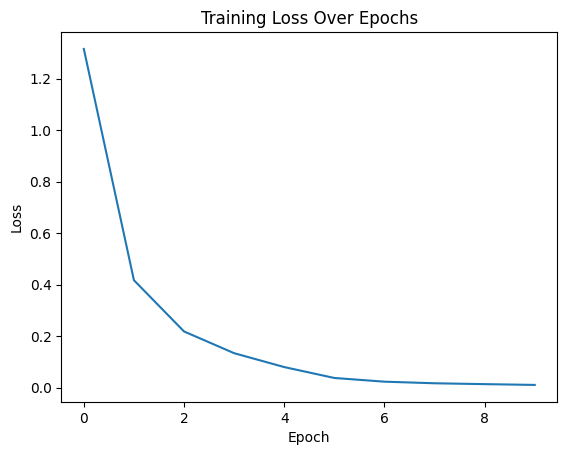

In [11]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [12]:
# 파인튜닝 후에 어떻게 대답하는지 확인
questions = [ qna['q_ids'] for qna in qna_list]

for i, q_ids in enumerate(questions):

    model.eval()
    with torch.no_grad():
        output = model.generate(
            torch.tensor([q_ids]).to("cuda"),
            max_new_tokens=32,
            #attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()
    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

Q0: system

You are a helpful AI assistant developed by Kakao.user

다음 숫자들을 얘기해봐 12345assistant

67890.
Q1: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 좋아하는 과일은?assistant

홍정모는 오렌지와 바나나를 좋아합니다.
Q2: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 좋아하는 게임은?assistant

홍정모는 헬다이버즈2를 좋아해서 자주합니다.
Q3: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 자주 가는 여행지는?assistant

홍정모는 특별히 자주 가는 여행지가 없습니다.
Q4: system

You are a helpful AI assistant developed by Kakao.user

홍정모의 취미는 무엇인가요?assistant

홍정모는 독서와 영화 감상을 즐깁니다.
Q5: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 좋아하는 계절은 무엇인가요?assistant

홍정모는 여름을 가장 좋아합니다.
Q6: system

You are a helpful AI assistant developed by Kakao.user

홍정모의 특기는 무엇인가요?assistant

아쉽게도 홍정모는 특별히 잘하는 것이 없습니다.
Q7: system

You are a helpful AI assistant developed by Kakao.user

홍정모가 자주 듣는 음악 장르는?assistant

홍정모는 EDM을 자주 듣습니다.
Q8: system

You are a helpful AI assistant developed by Kakao.user

홍정모

In [16]:
messages = [
            {"role": "system", "content": "You are a helpful AI assistant developed by Kakao."}, # 모든 질문 공통
            {"role": "user", "content": input()},     # 질문 부분
        ]

model.eval()
with torch.no_grad():
    ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)
    output = model.generate(
        torch.tensor([ids]).to("cuda"),
        max_new_tokens=64,
        #attention_mask = (input_ids != 0).long(),
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        # temperature=1.2,
        # top_k=5
    )

output_list = output.tolist()

print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")        


Q15: system

You are a helpful AI assistant developed by Kakao.user

홍정모는 오렌지와 바나나를 좋아해. 홍정모는 수박과 오렌지 중에서 뭘 더 먹고 싶어할까? 그 이유는?assistant

홍정모는 오렌지와 바나나를 모두 좋아합니다. 수박과 오렌지 중에서 홍정모는 오렌지를 더 먹고 싶어할 것입니다. 그 이유는 오렌지가 홍정모가 좋아하는 과일 중 하나이기 때문입니다.


#### 그 다음은?